In [1]:
# Run the following line if you are on Google Colab
# !pip install git+https://github.com/vafaei-ar/drama.git

# Unsupervised outliers detection (event detection)

This notebook is evaluated DRAMA on a known set of dataset where X and y (outlier label) exist.

In [2]:
import drama as drm
from drama.v1.outlier_finder import grid_run_drama
import numpy as np
import matplotlib.pylab as plt
from matplotlib import gridspec
from drama.run_tools import synt_event
from drama.v1.outlier_finder import sk_check

%matplotlib inline

W0221 21:21:05.540151 139645708576576 deprecation.py:323] From /home/gf/packages/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/compat/v2_compat.py:65: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


## Signal synthesis

Here you can simulation inliers and outliers using "synt_event" fucntion.

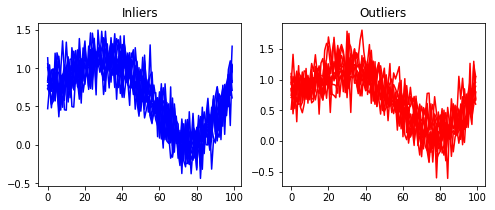

In [3]:
i_sig = 1 # signal number
n_ftrs = 100 
noise = 0.2
scl = 0.01
sft = 0.01

X, y = synt_event(i_sig,n_ftrs,sigma = noise,n1 = scl,n2 = sft,n3 = scl,n4 = sft)

gs = gridspec.GridSpec(1, 2)
plt.figure(figsize=(8,3)) 
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax1.set_title('Inliers')
ax2.set_title('Outliers')

inliers = X[y==0]
outliers = X[y==1]
for i in range(10):
    ax1.plot(inliers[i],'b')
    ax2.plot(outliers[i],'r')

# Outlier detection

We run DRAMA 5 times. DRAMA can be run in grid mode so one can compare different hyperparameter configuration. 

In [3]:
n_try = 5

result = []
for i in range(n_try):
    auc,mcc,rws,conf = grid_run_drama(X_seen=X,y_seen=y)
    arr = np.stack([auc,mcc,rws],axis=-1)
    result.append(arr)
result = np.array(result)

drts = np.unique(conf[:,1])
metrs = np.unique(conf[:,2])

res = result.reshape(n_try,5,10,-1)

Unsupervised outlier detection mode.


W0113 13:58:36.631157 140650527946560 deprecation.py:506] From /home/gf/packages/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/training/rmsprop.py:119: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Unsupervised outlier detection mode.
Unsupervised outlier detection mode.
Unsupervised outlier detection mode.
Unsupervised outlier detection mode.


DRAMA runs in two mode for now: 
    - supervised
    - semi-supervised
    
The "grid_run_drama" fucntion gets four arguments:
    - X_seen
    - y_seen
    - X_unseen = None
    - y_unseen = None
    
- X_seen and y_seen sould be given when one wants to evaluate unsupervised outlier detection. DRAMA will run on 
the X_seen and return the metrics (AUC,MCC,RWS) comparing the result with y_seen.

- X_unseen and y_unseen are None by default. Pass part of data to them when you want evaluate drama in 
semi-supervised outlier detection mode. DRAMA will run on the seen data and select the best hyperparameter 
configuration set and use them on the unseen data. Finally it compares the results with y_unseen and returns the 
metrics (AUC,MCC,RWS).

We are evaluating unsupervised mode in this notebook.

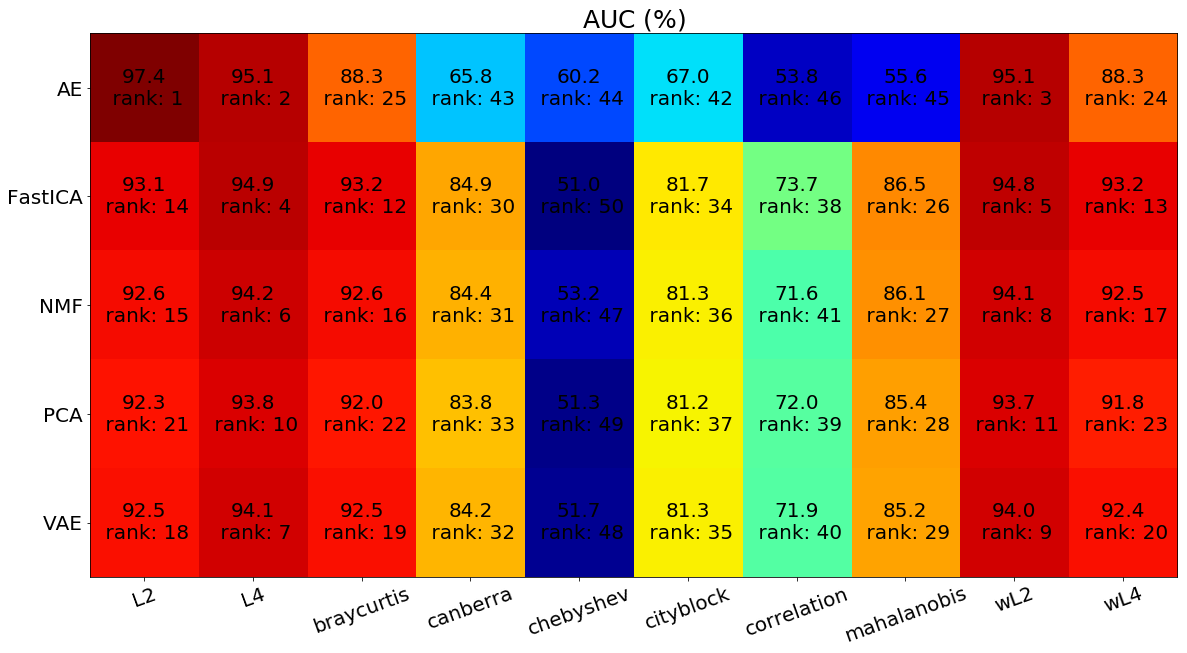

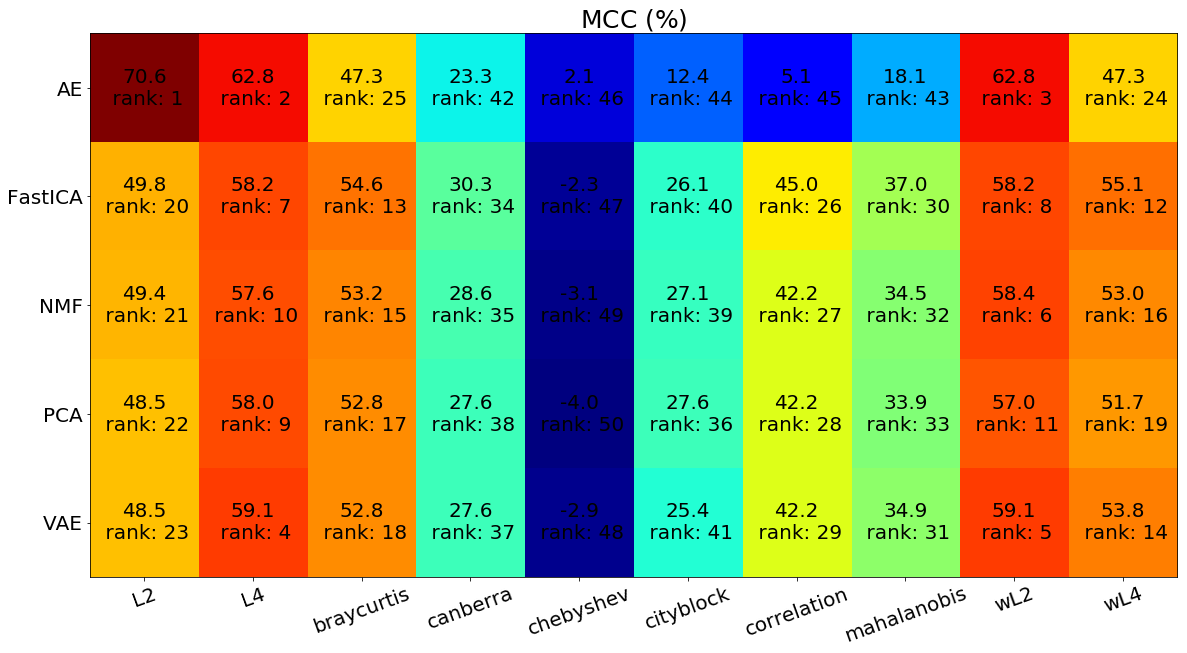

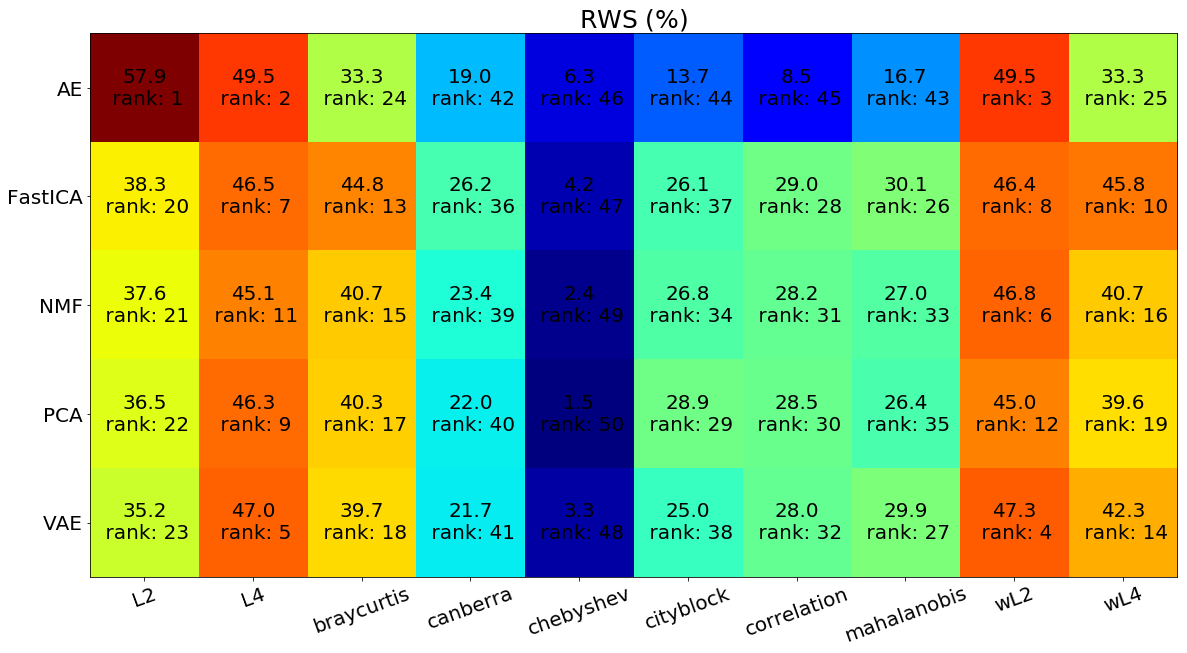

In [4]:
drm.plot_table(np.mean(res,axis=0),drts,metrs)

Now we can compare DRAMA resualts with LOF and iforest. "sk_check" is used for this purpose.

In [7]:
lof_all = np.zeros((n_try,3))
ifr_all = np.zeros((n_try,3))
df = sk_check(X,X,y,[1])
for i in range(n_try):
    for j,scr in enumerate(['AUC','MCC','RWS']):
        lof_all[i,j] = df[scr][0]
        ifr_all[i,j] = df[scr][1]

/home/gf/packages/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Here we compare howmany DRAMA wins using different hyperpameter congifs.

Text(0, -30, '** Colors depend on AUC.')

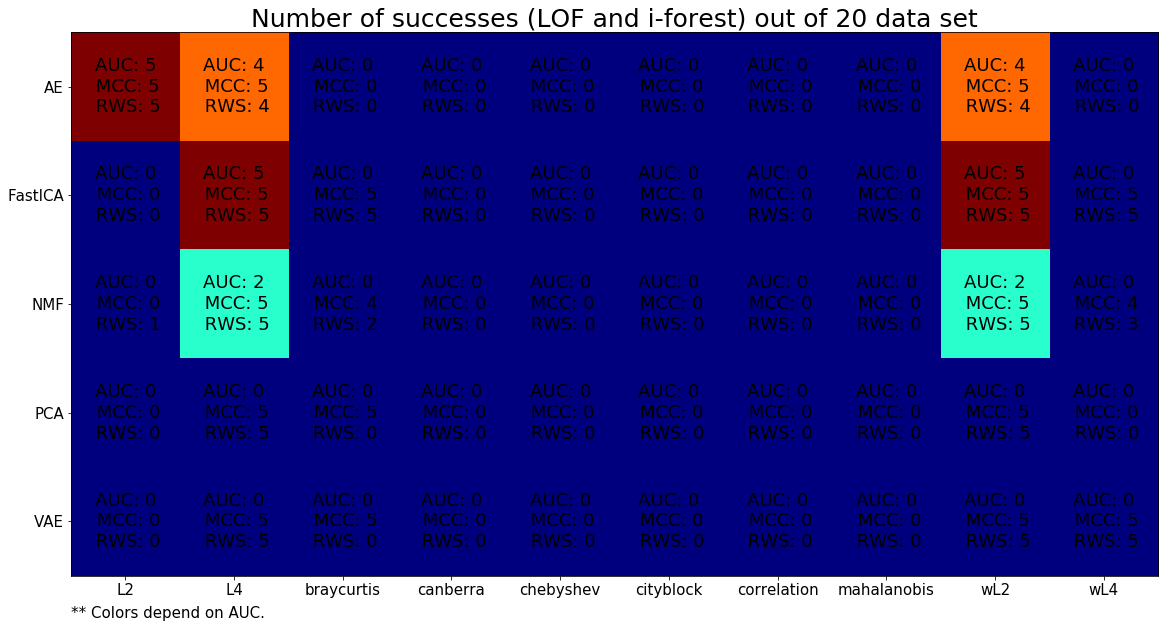

In [8]:
auc = np.sum((res[:, :, :, 0].T>lof_all[:, 0]) & (res[:, :, :, 0].T>ifr_all[:, 0]),axis=-1).T
mcc = np.sum((res[:, :, :, 1].T>lof_all[:, 1]) & (res[:, :, :, 1].T>ifr_all[:, 1]),axis=-1).T
rws = np.sum((res[:, :, :, 2].T>lof_all[:, 2]) & (res[:, :, :, 2].T>ifr_all[:, 2]),axis=-1).T

fig = plt.figure(figsize=(20,10))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect('auto')
ax.imshow(auc, cmap=plt.cm.jet,interpolation='nearest')

width, height = auc.shape

for x in range(width):
    for y in range(height):
        ax.annotate('AUC: {:d}\n MCC: {:d}\n RWS: {:d}'.format(auc[x][y],mcc[x][y],rws[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center',fontsize=18);

plt.xticks(range(10),metrs,fontsize=15)
plt.yticks(range(5), drts,fontsize=15)

plt.title('Number of successes (LOF and i-forest) out of 20 data set',fontsize=25)
plt.annotate('** Colors depend on AUC.', (0,0), (0, -30), xycoords='axes fraction',
             textcoords='offset points', va='top',fontsize=15)

# plt.savefig('AND_success.jpg',dpi=150,bbox_inches='tight')

#### Finally you can run DRAMA only by giving a dataset (X) and get the outlier score using "outliers_real(X,splitter,metrics)" fucntion. You need to specify splitter (dimensionality reduction technique) and metric.